# **ARIMA**

In [1]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", message=".*no associated frequency information.*")
#warnings.filterwarnings("ignore", message=".*Non-stationary starting.*")
#warnings.filterwarnings("ignore", message=".*Non-invertible starting.*")

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


In [2]:
csv_url=pd.read_csv("/content/nvidia_stock_cleaned.csv")
df=csv_url
df.head(10)

,date,open,high,low,close,adjclose,volume
0,2015-01-02,0.50325,0.50700,0.49525,0.50325,0.483218,113680000
1,2015-01-05,0.50325,0.50475,0.49250,0.49475,0.475056,197952000
2,2015-01-06,0.49550,0.49600,0.47925,0.47975,0.460654,197764000
3,2015-01-07,0.48325,0.48750,0.47700,0.47850,0.459453,321808000
4,2015-01-08,0.48400,0.49950,0.48375,0.49650,0.476737,283780000
5,2015-01-09,0.49825,0.50225,0.49150,0.49850,0.478657,209540000
6,2015-01-12,0.49975,0.50000,0.48775,0.49225,0.472656,190732000
7,2015-01-13,0.49600,0.50600,0.48800,0.49150,0.471936,236720000
8,2015-01-14,0.48625,0.49500,0.48500,0.49350,0.473856,155260000
9,2015-01-15,0.49700,0.50000,0.48975,0.49000,0.470496,188932000


In [3]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df = df.asfreq(df.index.inferred_freq or 'B')
df=df[['close']].dropna()
df.index=pd.DatetimeIndex(df.index)
df.index.freq=df.index.inferred_freq
ts=df['close']

In [4]:
train_size=int(len(ts)*0.8)
train=ts[:train_size]
test=ts[train_size:]

In [5]:
train.index = pd.DatetimeIndex(train.index)
train.index.freq = train.index.inferred_freq

In [6]:
auto_model=auto_arima(train,seasonal=False,stepwise=True,suppress_warnings=True)
p,d,q=auto_model.order
print(f"Best ARIMA order: (p={p}, d={d}, q={q})")
model=ARIMA(train,order=(p,d,q))
fitted_model=model.fit()

Best ARIMA order: (p=2, d=1, q=1)


In [7]:
forecast = fitted_model.forecast(steps=len(test))
forecast_series = pd.Series(forecast, index=test.index)

In [8]:
mae = mean_absolute_error(test, forecast)
rmse = root_mean_squared_error(test,forecast)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 26.20
RMSE: 35.96


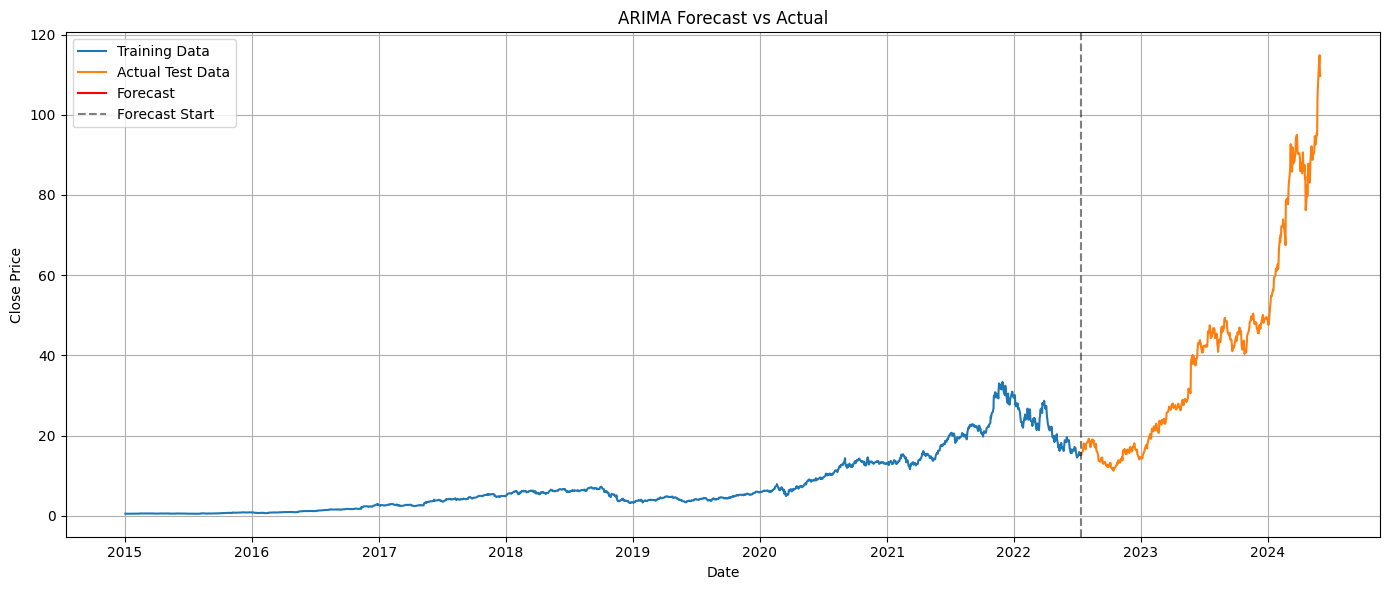

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.axvline(test.index[0], color='black', linestyle='--', alpha=0.5, label='Forecast Start')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
final_model=ARIMA(ts,order=(p,d,q))
final_fit=final_model.fit()
future_steps=180

In [11]:
future_forecast=final_fit.get_forecast(steps=future_steps)
future_mean=future_forecast.predicted_mean
conf_int=future_forecast.conf_int()

In [12]:
last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='B')

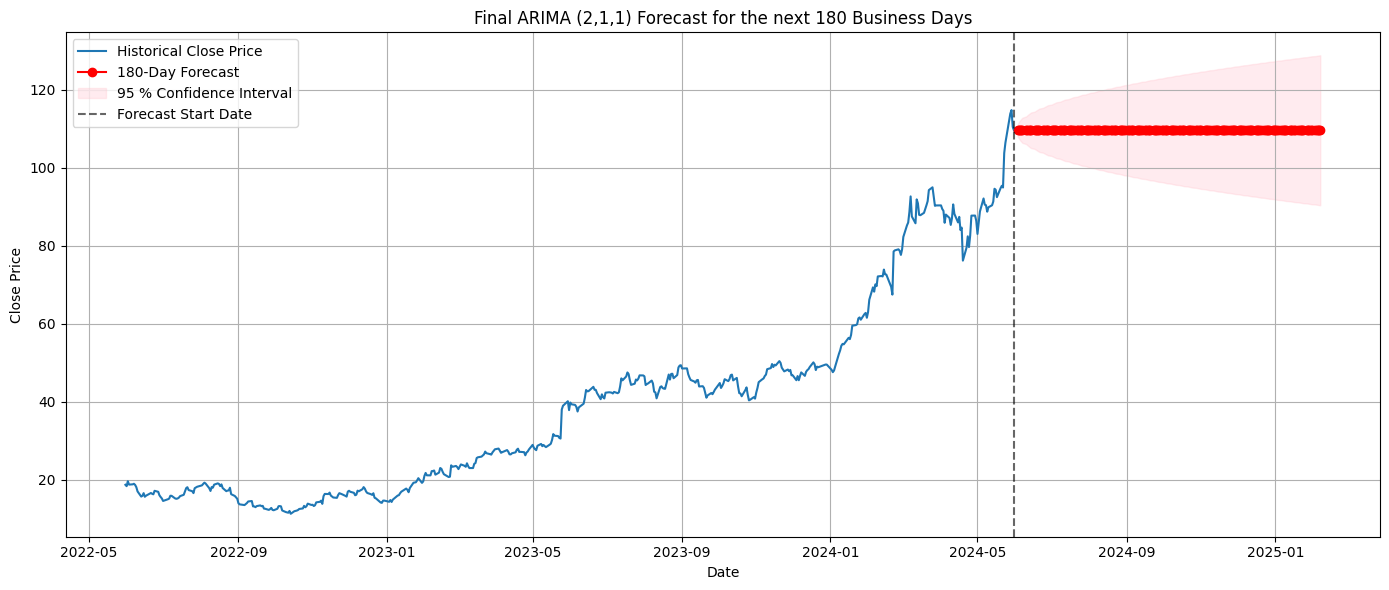

In [13]:
plt.figure(figsize=(14,6))
recent_data = ts[ts.index >= ts.index[-252*2]]  # roughly last 2 years of business days
plt.plot(recent_data, label="Historical Close Price")
plt.plot(future_dates,future_mean,label='180-Day Forecast',color='red',marker='o',linestyle='solid')
plt.fill_between(future_dates,conf_int.iloc[:,0],conf_int.iloc[:,1],color='pink',alpha=0.3,label='95 % Confidence Interval')
plt.axvline(x=last_date,color='black',linestyle='--',alpha=0.6,label='Forecast Start Date')
plt.title(f"Final ARIMA ({p},{d},{q}) Forecast for the next 180 Business Days")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **SARIMA**

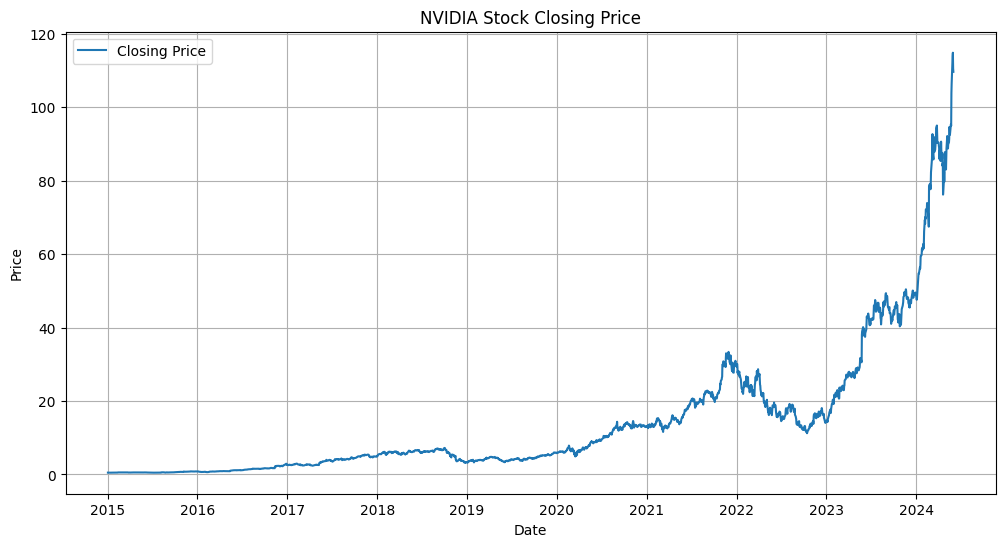

In [27]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("/content/nvidia_stock_cleaned.csv")


df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Closing Price')
plt.title("NVIDIA Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [30]:
# 1. Load and Prepare Data
df = pd.read_csv("/content/nvidia_stock_cleaned.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ts = df['close'].asfreq('D')  # daily frequency, forward fill missing if needed
ts = ts.fillna(method='ffill')

In [31]:
# 2. Check Stationarity
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'\nADF Statistic for {title}: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    return result[1]

print("== Stationarity Check ==")
d = 0
p_value = adf_test(ts, 'Original Series')
while p_value > 0.05:
    ts = ts.diff().dropna()
    d += 1
    p_value = adf_test(ts, f'Differenced {d} times')
print(f"\nOptimal d: {d}")

== Stationarity Check ==

ADF Statistic for Original Series: 4.9331
p-value: 1.0000

ADF Statistic for Differenced 1 times: -7.0218
p-value: 0.0000

Optimal d: 1


In [32]:
# 3. Train-Test Split
orig_ts = df['close'].asfreq('D').fillna(method='ffill')
train_size = int(len(orig_ts) * 0.8)
train, test = orig_ts[:train_size], orig_ts[train_size:]

In [33]:
# 4. SARIMA Grid Search
print("\n== Grid Search for SARIMA (p,d,q)x(P,D,Q,s) ==")
s = 7  # weekly seasonality
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

for p in range(0, 3):
    for q in range(0, 3):
        for P in range(0, 2):
            for Q in range(0, 2):
                try:
                    model = SARIMAX(train,
                                    order=(p, d, q),
                                    seasonal_order=(P, 1, Q, s),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    results = model.fit(disp=False)
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_seasonal_order = (P, 1, Q, s)
                        best_model = results
                    print(f"✅ SARIMA{(p,d,q)}x{(P,1,Q,s)} - AIC: {results.aic:.2f}")
                except Exception as e:
                    print(f"❌ Failed SARIMA{(p,d,q)}x{(P,1,Q,s)}")
                    continue

print(f"\n✅ Best SARIMA Order: {best_order} x {best_seasonal_order} with AIC={best_aic:.2f}")


== Grid Search for SARIMA (p,d,q)x(P,D,Q,s) ==
✅ SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC: 2948.63
✅ SARIMA(0, 1, 0)x(0, 1, 1, 7) - AIC: 1192.27
✅ SARIMA(0, 1, 0)x(1, 1, 0, 7) - AIC: 2294.62
✅ SARIMA(0, 1, 0)x(1, 1, 1, 7) - AIC: 1195.61
✅ SARIMA(0, 1, 1)x(0, 1, 0, 7) - AIC: 2923.85
✅ SARIMA(0, 1, 1)x(0, 1, 1, 7) - AIC: 1181.84
✅ SARIMA(0, 1, 1)x(1, 1, 0, 7) - AIC: 2265.95
✅ SARIMA(0, 1, 1)x(1, 1, 1, 7) - AIC: 1183.74
✅ SARIMA(0, 1, 2)x(0, 1, 0, 7) - AIC: 2907.97
✅ SARIMA(0, 1, 2)x(0, 1, 1, 7) - AIC: 1175.50
✅ SARIMA(0, 1, 2)x(1, 1, 0, 7) - AIC: 2250.18
✅ SARIMA(0, 1, 2)x(1, 1, 1, 7) - AIC: 1176.17
✅ SARIMA(1, 1, 0)x(0, 1, 0, 7) - AIC: 2928.60
✅ SARIMA(1, 1, 0)x(0, 1, 1, 7) - AIC: 1183.27
✅ SARIMA(1, 1, 0)x(1, 1, 0, 7) - AIC: 2271.78
✅ SARIMA(1, 1, 0)x(1, 1, 1, 7) - AIC: 1185.61
✅ SARIMA(1, 1, 1)x(0, 1, 0, 7) - AIC: 2731.94
✅ SARIMA(1, 1, 1)x(0, 1, 1, 7) - AIC: 1180.43
✅ SARIMA(1, 1, 1)x(1, 1, 0, 7) - AIC: 2261.69
✅ SARIMA(1, 1, 1)x(1, 1, 1, 7) - AIC: 1182.06
✅ SARIMA(1, 1, 2)x(0, 1, 0, 7) -

In [34]:
# 5. Forecast and Evaluate
forecast = best_model.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Drop NaNs if any
comparison = pd.DataFrame({'actual': test, 'forecast': forecast}).dropna()

# Evaluation
mae = mean_absolute_error(comparison['actual'], comparison['forecast'])
rmse = np.sqrt(mean_squared_error(comparison['actual'], comparison['forecast']))
print(f"\n== Evaluation ==")
print(f"MAE : {mae:.6f}")
print(f"RMSE: {rmse:.6f}")


== Evaluation ==
MAE : 24.526334
RMSE: 33.921864


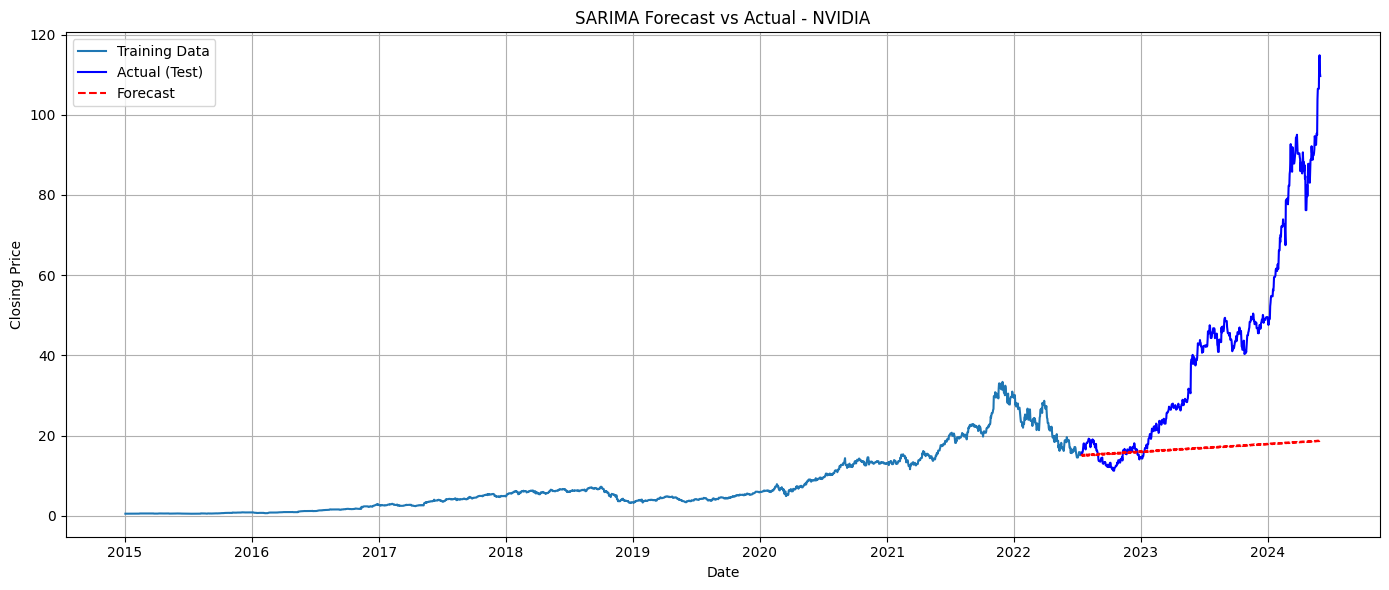

In [35]:
# 6. Plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual (Test)', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title("SARIMA Forecast vs Actual - NVIDIA")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

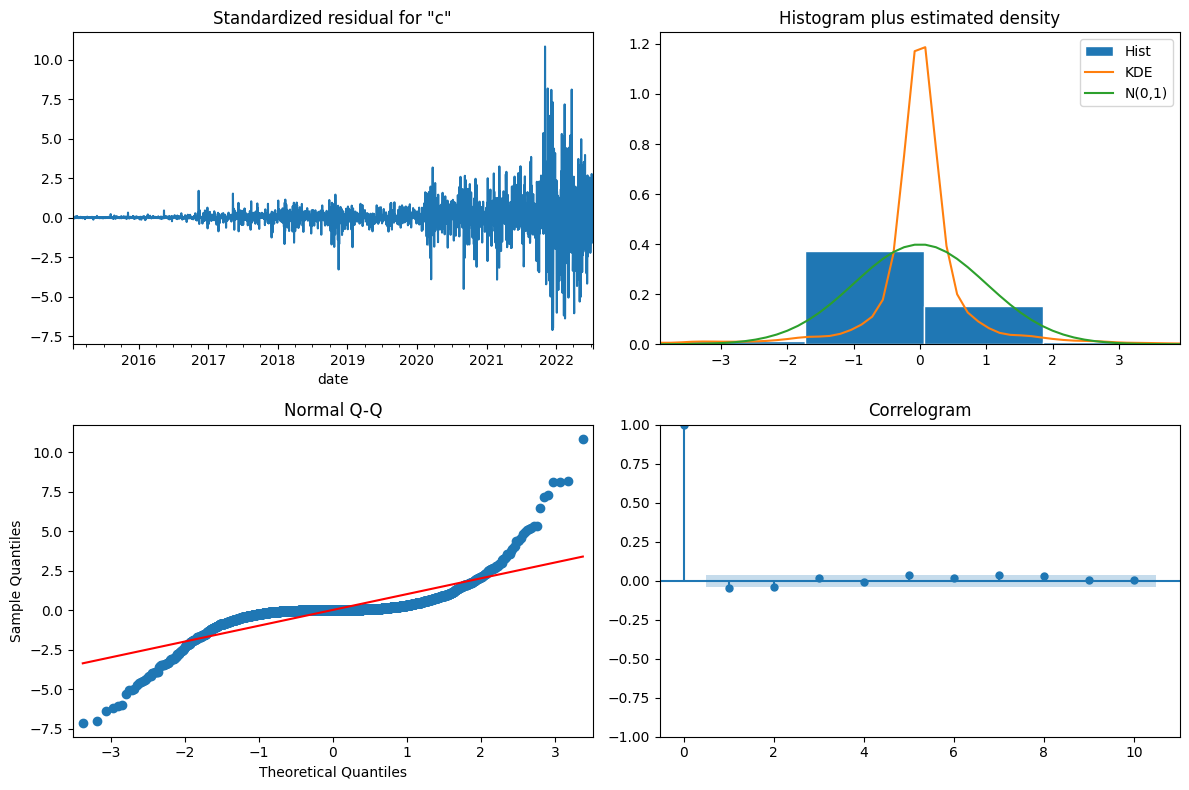

In [36]:
# 7. Optional: Diagnostics
best_model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

# **PROPHET**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv("/content/nvidia_stock_cleaned.csv")
df.head(10)

,date,open,high,low,close,adjclose,volume
0,2015-01-02,0.50325,0.50700,0.49525,0.50325,0.483218,113680000
1,2015-01-05,0.50325,0.50475,0.49250,0.49475,0.475056,197952000
2,2015-01-06,0.49550,0.49600,0.47925,0.47975,0.460654,197764000
3,2015-01-07,0.48325,0.48750,0.47700,0.47850,0.459453,321808000
4,2015-01-08,0.48400,0.49950,0.48375,0.49650,0.476737,283780000
5,2015-01-09,0.49825,0.50225,0.49150,0.49850,0.478657,209540000
6,2015-01-12,0.49975,0.50000,0.48775,0.49225,0.472656,190732000
7,2015-01-13,0.49600,0.50600,0.48800,0.49150,0.471936,236720000
8,2015-01-14,0.48625,0.49500,0.48500,0.49350,0.473856,155260000
9,2015-01-15,0.49700,0.50000,0.48975,0.49000,0.470496,188932000


In [16]:
df.shape

(2369, 7)

In [17]:
df.isnull().sum()

,0
date,0
open,0
high,0
low,0
close,0
adjclose,0
volume,0


In [18]:
df.dtypes

,0
date,object
open,float64
high,float64
low,float64
close,float64
adjclose,float64
volume,int64


In [19]:
from prophet import Prophet

In [21]:
df['date']=pd.to_datetime(df['date'])
prophet_df=df[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})
prophet_df

,ds,y
0,2015-01-02,0.503250
1,2015-01-05,0.494750
2,2015-01-06,0.479750
3,2015-01-07,0.478500
4,2015-01-08,0.496500
...,...,...
2364,2024-05-24,106.469002
2365,2024-05-28,113.901001
2366,2024-05-29,114.824997
2367,2024-05-30,110.500000


In [22]:
model=Prophet()
model.fit(prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxkifth6/4qasflrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxkifth6/1rnm4si_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76956', 'data', 'file=/tmp/tmprxkifth6/4qasflrb.json', 'init=/tmp/tmprxkifth6/1rnm4si_.json', 'output', 'file=/tmp/tmprxkifth6/prophet_modelkl89hiag/prophet_model-20250708134710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:47:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
future=model.make_future_dataframe(periods=90,freq='B')
forecast=model.predict(future)

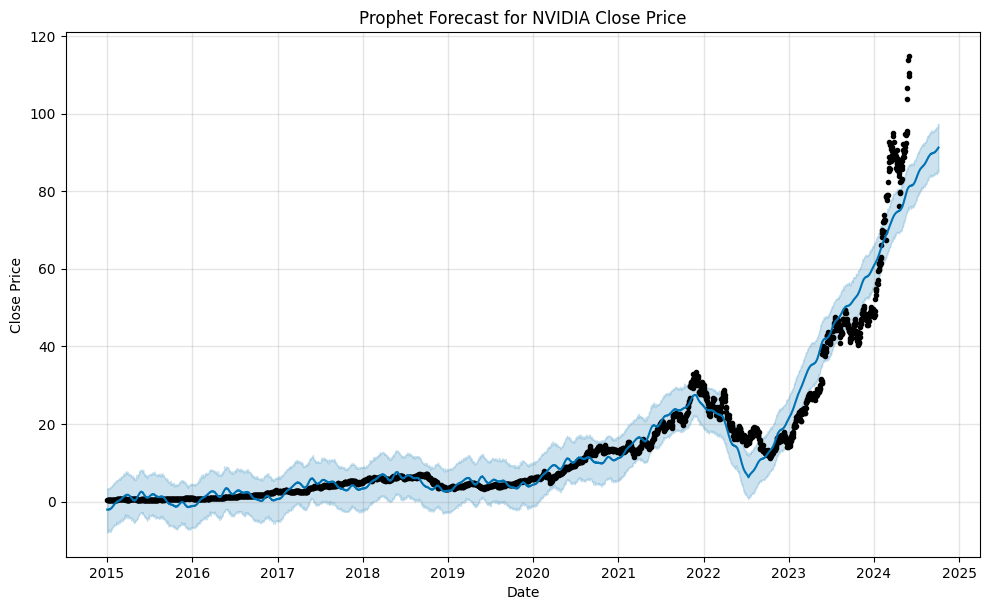

In [24]:
fig1 = model.plot(forecast)
plt.title("Prophet Forecast for NVIDIA Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [25]:
merged=pd.merge(prophet_df,forecast[['ds','yhat']],on='ds',how='left')
actual=merged.dropna()
mae=mean_absolute_error(actual['y'], actual['yhat'])
rmse=np.sqrt(mean_squared_error(actual['y'], actual['yhat']))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2.67
RMSE: 4.30


# **LSTM**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
# === Step 2: Load NVIDIA Stock Data ===
df = pd.read_csv("/content/nvidia_stock_cleaned.csv")
df.head(10)

,date,open,high,low,close,adjclose,volume
0,2015-01-02,0.50325,0.50700,0.49525,0.50325,0.483218,113680000
1,2015-01-05,0.50325,0.50475,0.49250,0.49475,0.475056,197952000
2,2015-01-06,0.49550,0.49600,0.47925,0.47975,0.460654,197764000
3,2015-01-07,0.48325,0.48750,0.47700,0.47850,0.459453,321808000
4,2015-01-08,0.48400,0.49950,0.48375,0.49650,0.476737,283780000
5,2015-01-09,0.49825,0.50225,0.49150,0.49850,0.478657,209540000
6,2015-01-12,0.49975,0.50000,0.48775,0.49225,0.472656,190732000
7,2015-01-13,0.49600,0.50600,0.48800,0.49150,0.471936,236720000
8,2015-01-14,0.48625,0.49500,0.48500,0.49350,0.473856,155260000
9,2015-01-15,0.49700,0.50000,0.48975,0.49000,0.470496,188932000


In [3]:
df.isnull().sum()

,0
date,0
open,0
high,0
low,0
close,0
adjclose,0
volume,0


In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df[['close']].dropna()
df.columns = ['Close']
df.head(10)

,Close
date,
2015-01-02,0.50325
2015-01-05,0.49475
2015-01-06,0.47975
2015-01-07,0.47850
2015-01-08,0.49650
2015-01-09,0.49850
2015-01-12,0.49225
2015-01-13,0.49150
2015-01-14,0.49350


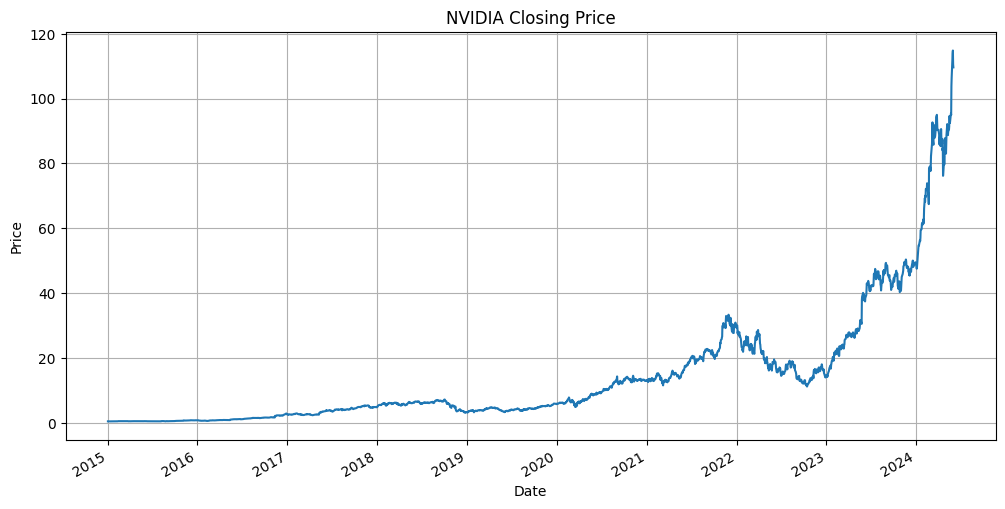

In [5]:
# === Step 3: Visualization ===
plt.figure(figsize=(12, 6))
df['Close'].plot(title='NVIDIA Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

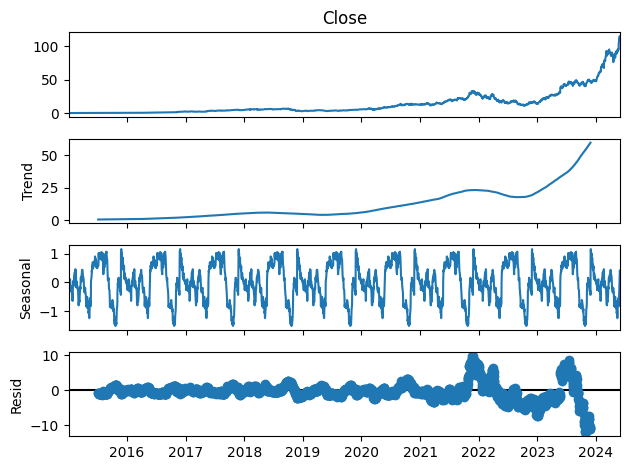

In [6]:
# === Step 4: Seasonal Decomposition ===
decompose = seasonal_decompose(df['Close'], model='additive', period=252)
decompose.plot()
plt.show()


In [7]:
# === Step 7: LSTM ===
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

train_size = int(len(df_scaled) * 0.85)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Create sequences
def create_dataset(dataset, time_step=90):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(90, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1, validation_data=(X_test, y_test))

lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 1.2421e-04 - val_loss: 0.0015
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 1.1223e-04 - val_loss: 0.0034
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 1.1665e-04 - val_loss: 0.0024
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 9.6870e-05 - val_loss: 0.0029
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 9.8682e-05 - val_loss: 0.0021
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 8.2508e-05 - val_loss: 0.0020
Epoch 8/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 7.1729e-05 - val_loss: 0.0020
Epoch 9/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 7.7349e-05 - val_loss: 0.0012
Epoch 10/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 8.7208e-05 - val_loss: 0.0015
Epoch 11/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 8.6842e-05 - val_loss: 0.

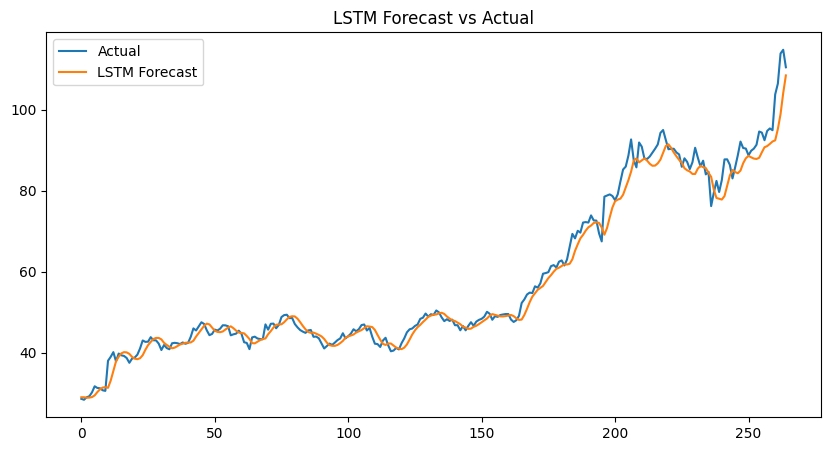

In [8]:
# Plot LSTM Forecast vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(lstm_pred, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()

In [9]:

# === Step 8: Evaluation ===
def evaluate_model(true, pred):
    rmse = math.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')


print("\nLSTM Evaluation:")
evaluate_model(y_test_rescaled, lstm_pred)

# === Optional: Save Results ===
df.to_csv("nvidia_stock_data_used.csv")



LSTM Evaluation:
RMSE: 2.93, MAE: 1.96


In [10]:
##Fine tuning
from keras.layers import Bidirectional

# Adjust time step and batch size
X_train, y_train = create_dataset(train, time_step=60)
X_test, y_test = create_dataset(test, time_step=60)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build a deeper Bidirectional LSTM
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(60, 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and scale back
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 2.4282e-04 - val_loss: 0.0026
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 1.2406e-04 - val_loss: 0.0022
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 9.0420e-05 - val_loss: 0.0013
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 1.1306e-04 - val_loss: 7.8042e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 1.0035e-04 - val_loss: 0.0026
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 1.0098e-04 - val_loss: 8.2593e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 8.7527e-05 - val_loss: 0.0013
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 1.0158e-04 - val_loss: 0.0018
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 9.7212e-05 - val_loss: 0.0027
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 8.6989e-05 - val_loss: 0.0018
Epoch 12/

In [11]:
##after tuning
print("\nLSTM Evaluation:")
evaluate_model(y_test_rescaled, lstm_pred)


LSTM Evaluation:
RMSE: 2.79, MAE: 1.94


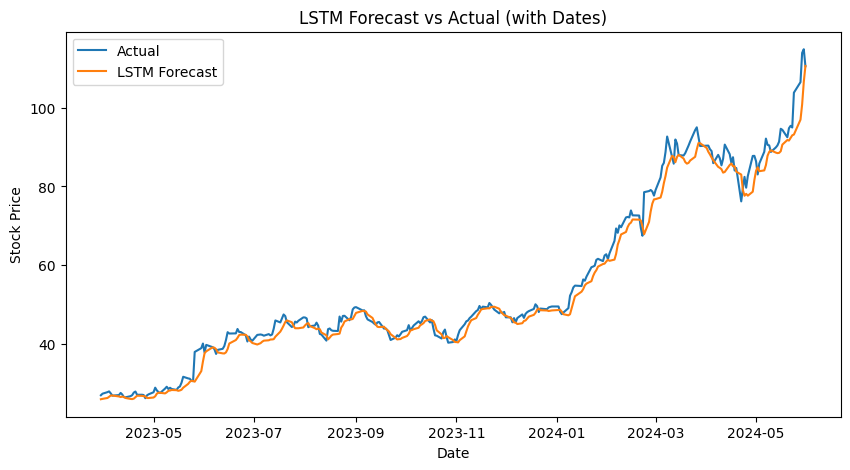

In [12]:

test_dates = df.index[-len(y_test_rescaled):]

plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_rescaled, label='Actual')
plt.plot(test_dates, lstm_pred, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual (with Dates)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()